On this notebook we'll analyze the data we've previously extracted and cleaned.

For that, let's first add a couple of libraries that we'll be using and import our dataset

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# We specify the columns to use, to avoid including the unnamed index column
df = pd.read_csv('data/processed_data.csv', usecols=['text', 'date', 'favorited', 'retweeted', 'replies', 'user', 'lang'])

In [3]:
df.head()

,text,date,favorited,retweeted,replies,user,lang
0,"Los ""pollos"" queremos un Presidente ""pollo"". U...",2018-01-27 22:24:45,629,336,85,708108228568207360,es
1,Vota por @IvanDuque en la consulta @CeDemocrat...,2018-01-27 21:51:25,793,535,136,149281495,es
2,Compartimos con alegría nuestra propuesta de p...,2018-01-27 21:50:15,188,119,4,77653794,es
3,.@FNAraujoR #4 Senado @IvanDuque #ElCandidato...,2018-01-27 21:46:13,34,27,2,1069678676,es
4,The girls flocking to see Mr. Duque. That's g...,2018-01-27 20:54:10,1,0,0,876674787115925504,en


In [4]:
# We convert the date column to have date format
df['date'] = pd.to_datetime(df['date'])

In [5]:
# And we use it as the index for the dataset
df.set_index('date', inplace=True)

And now we're ready to start exploring our data.

# Basic analysis

Let's look at some basic statistics first

In [6]:
df.describe()

,favorited,retweeted,replies,user
count,27695.000000,27695.000000,27695.000000,2.769500e+04
mean,272.659289,141.743022,24.384871,1.101582e+17
std,818.115387,368.529151,91.420453,2.906389e+17
min,0.000000,0.000000,0.000000,7.820760e+05
25%,21.000000,10.000000,1.000000,1.145778e+08
50%,59.000000,34.000000,3.000000,2.847087e+08
75%,189.000000,112.000000,13.000000,1.668436e+09
max,28728.000000,9909.000000,3242.000000,1.006637e+18


From this, we can see a couple of things. For example, we can see that the mean of likes is strongly affected by outliers. This can be seen in that our third quartile is at 189 likes, and the mean is at 272. This means that the mean is being pulled greatly by the most favorited tweets.

The same happens with the number of retweets.

Let's see the count of tweets in the different languages Twitter identified

In [7]:
df['lang'].value_counts()

es     24287
en      3058
und      287
pt        35
ca         8
fr         5
it         4
tl         3
et         3
in         2
ht         1
no         1
hu         1
Name: lang, dtype: int64

So according to this, there are tweets in various languages mentioning the presidential candidates. However, if we examine them, we'll see that many are misclassified. For instance let's take a look at the tweets classified as catalan:

In [8]:
for text in df[df['lang'] == 'ca']['text']:
    print("=" * 80)
    print(text)
    print("=" * 80)

La gran fórmula. @MJaramilloLujan @Ricardo_Rojas_E @IvanDuque @AlvaroUribeVel @claudiapalacios @Cusugagutierrez @majagual @jcjurado1 pic.twitter.com/aO4yoc9wan
TOTAL !!!
Comite voluntarios Duitsma Cívica Con Duque @AlvaroUribeVel @IvanDuque @CIROARAMIREZ @CeDemocratico @CeDemocratico @Ricardo7dias @boyacasietedias pic.twitter.com/duzrSu0BVD
Atacó - Tolima                                        Comité Voluntario-S/ Construccion  @IvanDuque Pte @mluciaramirez VicePte                             @CeDemocratico @ComiteCivDura pic.twitter.com/dUfBTmsORl
Toma Comuna 12 #Bucaramanga @IvanDuque #DuquePresidenteEnPrimeraVuelta @EdwBallesteros #YoRespondoPorSantander @GermanEspejo_ @SophyCh_E @linamcardonag @totorangelm @Setulus1 pic.twitter.com/uLakIgn9mL
#PetroEnBoyaca Duitama con #ColombiaHumana @petrogustavo pic.twitter.com/vhncSAGxhD
"EL" INNOMBRABLE @AlvaroUribeVel AUCD  NHM @FiscaliaCol ? @gener_usuga @AlirioUribeMuoz @IvanCepedaCast @petrogustavo @IndiraVegaP @EsperancitaUrib @adrisgame 

These are all actually in spanish, but, probably because of the short text, Twitter is misclassifying them.

## Adding the tweet length

Let's add the length of the tweets as an extra column to our dataframe, to see if it might give some insight

In [9]:
df['length'] = df['text'].str.len()

df.head()

,text,favorited,retweeted,replies,user,lang,length
date,,,,,,,
2018-01-27 22:24:45,"Los ""pollos"" queremos un Presidente ""pollo"". U...",629,336,85,708108228568207360,es,197.0
2018-01-27 21:51:25,Vota por @IvanDuque en la consulta @CeDemocrat...,793,535,136,149281495,es,121.0
2018-01-27 21:50:15,Compartimos con alegría nuestra propuesta de p...,188,119,4,77653794,es,190.0
2018-01-27 21:46:13,.@FNAraujoR #4 Senado @IvanDuque #ElCandidato...,34,27,2,1069678676,es,300.0
2018-01-27 20:54:10,The girls flocking to see Mr. Duque. That's g...,1,0,0,876674787115925504,en,50.0


And now we've got a length column with the length of each tweet.

## Adding columns to identify the mentioned candidates

Now let's add an extra couple of columns to tell if one of the candidates is mentioned (or if both are). We'll call these 'mentions_duque' and 'mentions_petro'.

In [10]:
df['mentions_duque'] = df['text'].str.lower().str.contains('@ivanduque')
df['mentions_petro'] = df['text'].str.lower().str.contains('@petrogustavo')

# Let's set those columns as boolean
df['mentions_duque'] = df['mentions_duque'].astype('bool')
df['mentions_petro'] = df['mentions_petro'].astype('bool')

df.tail(10)

,text,favorited,retweeted,replies,user,lang,length,mentions_duque,mentions_petro
date,,,,,,,,,
2018-06-17 23:37:36,Un claro triunfo de @IvanDuque . Una gran vota...,146,75,7,70594101,es,233.0,True,True
2018-06-17 23:37:08,"#ENVIVO ""Gracias a todos en el exterior, a los...",195,39,4,14834302,es,147.0,False,True
2018-06-17 23:36:37,El guerrillero @petrogustavo tiene derecho a d...,134,135,3,2388386342,es,271.0,False,True
2018-06-17 23:36:32,"Según el 99,92% de los votos escrutados, en #B...",162,155,49,76664119,es,214.0,True,True
2018-06-17 23:36:00,Quien le dijo a @petrogustavo q había ganado e...,28,36,2,99845052,es,111.0,False,True
2018-06-17 23:35:56,El discurso de @petrogustavo ratifica que él n...,91,72,4,123696230,es,163.0,False,True
2018-06-17 23:35:48,"You’re a fucking shit, I can’t understand how ...",1,0,0,752702142130036736,en,112.0,False,False
2018-06-17 23:35:22,"""La corrupción en Colombia está herida; la cla...",148,48,8,9633802,es,125.0,False,True
2018-06-17 23:35:11,"#ColombiaDecide | ""Esperamos que sea cierto qu...",108,29,6,18079284,es,208.0,False,True


Now we've got columns indicating which of the candidates is being mentioned, or if they both are.

Apparently, some tweets do not mention either of the candidates. Let's check those out to see if we should get rid of them.

In [11]:
for tweet in df[~df['mentions_duque'] & ~df['mentions_petro']]['text'][:10]:
    print(tweet)

Compartimos con alegría nuestra propuesta de país en #Medellín, juntos vamos a construir un país de #legalidad #emprendimiento y #equidad #ManoFirme #CorazónGrande pic.twitter.com/7JZKfbxiYR
The girls flocking to see Mr. Duque.  That's good.
Nuestro gobierno incentivará la inversión y el emprendimiento, buscará, con una agenda integral de recuperación económica y con responsabilidad fiscal, bajar impuestos y mejorar el salario de los trabajadores #Medellín pic.twitter.com/DFEW7027qU
Nosotros necesitamos volver a sembrar valores, a generar una cultura  de respeto a la ley, al prójimo, a la mujer. En nuestro gobierno le vamos a devolver al sistema educativo las cátedras de cívica y urbanidad para formar ciudadanos ejemplares #Medellín #Antioquia pic.twitter.com/BccKObHfib
Si el ELN se quiere desmovilizar, desarmar y reinsertar, que se concentre, suspenda actividades criminales y que se sometan a penas proporcionales y efectivas. Sino lo aceptan les caerá toda la capacidad ofensiva del Es

Some of these tweets were created by one of the candidates. So, let's get rid of the tweets created by the candidates, since we're not really interested on their sentiment towards one another.

In [12]:
df.drop(df[(df['user'] == 77653794) | (df['user'] == 49849732)].index, axis=0, inplace=True)

Now, let's check the tweets not mentioning any of the candidates again

In [15]:
for tweet in df[~df['mentions_duque'] & ~df['mentions_petro']]['text'][:10]:
    print(tweet)

The girls flocking to see Mr. Duque.  That's good.
Fajardo petardo google
The Winner is ; @A_OrdonezM  sin duda!!
No worries then
¡Horror!
El doctorcito Google.
Exacto
Yo tuve la oportunidad de leer el libro de Indignaccion con sus 162 propuestas (plan de gobierno) para la economía, educación, salud, empleo, cultura, agro, etc. El man la tiene clara.
Por eso lo dije quienes lo difaman no lo han escuchado como sabe de cada tema que le preguntan
Uichhhhhhj qué genio, si se le frota salen naranjas jajajajajaja jajajajajaja jajajajajajaja jajajja ya veo q #No trabajan sobre presión. Ja


In [14]:
df[~df['mentions_duque'] & ~df['mentions_petro']]

,text,favorited,retweeted,replies,user,lang,length,mentions_duque,mentions_petro
date,,,,,,,,,
2018-01-27 20:54:10,The girls flocking to see Mr. Duque. That's g...,1,0,0,876674787115925504,en,50.0,False,False
2018-01-27 18:05:48,Fajardo petardo google,1,0,0,116084446,en,22.0,False,False
2018-01-27 21:57:34,The Winner is ; @A_OrdonezM sin duda!!,1,0,0,118819583,en,39.0,False,False
2018-01-27 14:19:19,No worries then,0,0,0,234114512,en,15.0,False,False
2018-01-27 12:51:49,¡Horror!,2,2,2,185859540,en,8.0,False,False
2018-01-27 12:02:31,El doctorcito Google.,0,0,1,1249867920,en,21.0,False,False
2018-01-27 03:36:35,Exacto,1,0,0,2352871707,en,6.0,False,False
2018-01-27 00:08:44,Yo tuve la oportunidad de leer el libro de Ind...,1,0,0,1012007906,es,184.0,False,False
2018-01-27 00:08:41,Por eso lo dije quienes lo difaman no lo han e...,1,0,0,872771798,es,94.0,False,False


This reveals very important information, because these tweets, are replies to the candidates, which are crucial to our analysis. So, we'll need to update the data extractor to include this information as well. But for now, let's work with what we already have.

### Analyzing the tweets' length

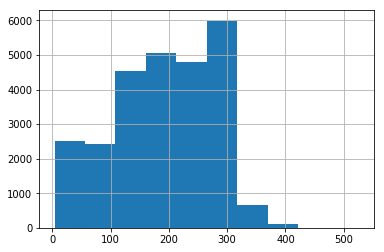

In [15]:
df['length'].hist()

According to this histogram, the tweet length has a sort of skewed distribution, with a mode near the 300 characters.

Now let's see if anything varies between the candidates or if it's rather similar.

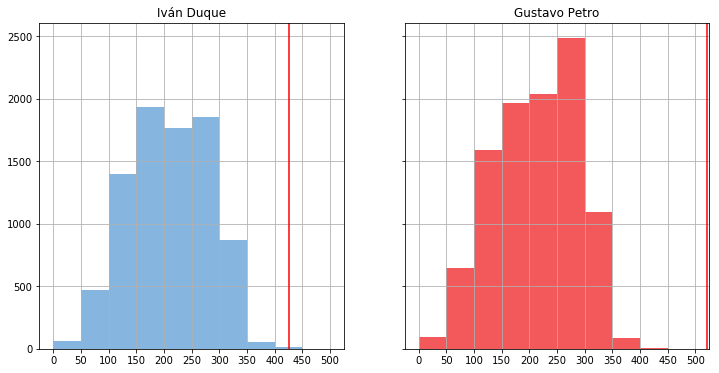

In [17]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))

xticks = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

df[df['mentions_duque'] & ~df['mentions_petro']]['length'].hist(ax=ax, color='#86B5E0', bins=xticks)
df[df['mentions_petro'] & ~df['mentions_duque']]['length'].hist(ax=ax2, color='#F3585A', bins=xticks)

# Add a vertical line to mark the max length
ax.axvline(max(df[df['mentions_duque'] & ~df['mentions_petro']]['length']), color='red')
ax.set(xticks=xticks, title='Iván Duque')

ax2.axvline(max(df[df['mentions_petro'] & ~df['mentions_duque']]['length']), color='red')
ax2.set(xticks=xticks, title='Gustavo Petro')

plt.show()

From these histograms we can see that the length of the tweets is basically a normal distribution, however, there's something with tweets mentioning Gustavo Petro, which had an abnormal amount of tweets between 250 and 300 characters. Also, it's possible to see that the longest tweets mentioned Gustavo Petro more than Ivan Duque. However, this is probably justified by the overall difference between the amount of tweets mentioning each of the candidates.

## Identifying most frequent words

Now, let's identify which words were used the most by the people mentioning the candidates.

For this, we'll need to create a corpus of the tweets mentioning each of the candidates; remove stopwords; and calculate the frequencies.

1. Creating corpus for the tweets mentioning the different candidates.

We'll create three different corpuses here. The first one will contain tweets mentioning just one of the candidates; the second one will contain tweets mentioning just the other candidate; and the third one will contain all of the tweets.

In [18]:
# First, remove columns without a text value
df = df[~df['text'].isnull()]

duque_corpus = " ".join(df[df['mentions_duque'] & ~ df['mentions_petro']]['text'])
petro_corpus = " ".join(df[df['mentions_petro'] & ~ df['mentions_duque']]['text'])
corpus = " ".join(df['text'])

Now, let's see what happens if we try to tokenize the text by simply using `*_corpus.split()`

In [19]:
duque_corpus.split()

['Los',
 '"pollos"',
 'queremos',
 'un',
 'Presidente',
 '"pollo".',
 'Un',
 'pollo',
 'fresco',
 'e',
 'innovador',
 'pero',
 'con',
 'las',
 'espuelas',
 'puestas',
 'por',
 '@AlvaroUribeVel',
 'Ese',
 '"pollo"',
 'es',
 '@IvanDuque',
 '#DuquePresidente',
 '@CeDemocratico',
 '@CarlosHolmesTru',
 'Vota',
 'por',
 '@IvanDuque',
 'en',
 'la',
 'consulta',
 '@CeDemocratico',
 'el',
 'partido',
 'del',
 'Uribismo',
 'y',
 'de',
 '@AlvaroUribeVel',
 'pic.twitter.com/7CzVECAOHu',
 '.@FNAraujoR',
 '#4',
 'Senado',
 '@IvanDuque',
 '#ElCandidatoDeLaEsperanza',
 '#1',
 'en',
 'la',
 'Consulta',
 'Interpartidista',
 '@AlvaroUribeVel',
 '#',
 '1',
 'Senado',
 '.@CeDemocratico',
 ',',
 'están',
 'sembrando',
 'Esperanza',
 'en',
 'cada',
 'Rincón',
 'de',
 'La',
 'Patria',
 'para',
 'que',
 'los',
 'tiempos',
 'de',
 'la',
 'Seguridad',
 'Democrática',
 'Regrese.',
 '#LoMejorEstaPorVenir',
 'pic.twitter.com/RWrmqrwYfm',
 '#FelizSábado,',
 'hoy',
 'durante',
 'reunión',
 'en',
 'Medellín',
 'el',
 

As you may see, we'll get some words wrapped in quotes, such as `"pollos"`, we'll get some words followed or preceded by periods, commas, or other punctuation marks, such as `.@CeDemocratico`, `#FelizSábado,`, `!Trabaremos`, `municipios!`, and others.

So, let's actually convert the corpuses into arrays by using `split()` and then clean them up a little

In [20]:
split_duque_corpus, split_petro_corpus, split_corpus = duque_corpus.split(), petro_corpus.split(), corpus.split()

print(len(split_duque_corpus), len(split_petro_corpus), len(split_corpus))

230650 283820 676107


Great. Now, let's define a function to remove these special characters.

In [21]:
import re

def remove_special_characters(text):
    period = re.compile("(\.|\:)")
    # We remove periods only if they're at the first or last position
    if period.match(text, 0, 1):
        text = text[1:]
    if period.match(text, len(text) - 1, len(text)):
        text = text[:-1]
    # And we remove special characters other than periods, hash signs, ad signs, letters with tildes, and numbers
    text = re.sub("[^\:a-zA-Z0-9áéíóúüñÁÉÍÓÚÑ\.#@\/\s]", "", text)
    # Finally, we return the lowercase version of the word
    return text.lower()

def clean_corpus(input_corpus):
    return [remove_special_characters(x) for x in input_corpus]

And now we can clean the corpuses

In [22]:
clean_duque_corpus = clean_corpus(split_duque_corpus)

clean_petro_corpus = clean_corpus(split_petro_corpus)

clean_whole_corpus = clean_corpus(split_corpus)

In [23]:
clean_duque_corpus

['los',
 'pollos',
 'queremos',
 'un',
 'presidente',
 'pollo',
 'un',
 'pollo',
 'fresco',
 'e',
 'innovador',
 'pero',
 'con',
 'las',
 'espuelas',
 'puestas',
 'por',
 '@alvarouribevel',
 'ese',
 'pollo',
 'es',
 '@ivanduque',
 '#duquepresidente',
 '@cedemocratico',
 '@carlosholmestru',
 'vota',
 'por',
 '@ivanduque',
 'en',
 'la',
 'consulta',
 '@cedemocratico',
 'el',
 'partido',
 'del',
 'uribismo',
 'y',
 'de',
 '@alvarouribevel',
 'pic.twitter.com/7czvecaohu',
 '@fnaraujor',
 '#4',
 'senado',
 '@ivanduque',
 '#elcandidatodelaesperanza',
 '#1',
 'en',
 'la',
 'consulta',
 'interpartidista',
 '@alvarouribevel',
 '#',
 '1',
 'senado',
 '@cedemocratico',
 '',
 'están',
 'sembrando',
 'esperanza',
 'en',
 'cada',
 'rincón',
 'de',
 'la',
 'patria',
 'para',
 'que',
 'los',
 'tiempos',
 'de',
 'la',
 'seguridad',
 'democrática',
 'regrese',
 '#lomejorestaporvenir',
 'pic.twitter.com/rwrmqrwyfm',
 '#felizsábado',
 'hoy',
 'durante',
 'reunión',
 'en',
 'medellín',
 'el',
 'expresident

In [24]:
# We create a couple of dicts to store the word frequencies
duque_freq = {}
petro_freq = {}
whole_freq = {}

# We populate the word frequency map
for word in clean_duque_corpus:
    duque_freq[word] = duque_freq.get(word, 0) + 1

for word in clean_petro_corpus:
    petro_freq[word] = petro_freq.get(word, 0) + 1
    
for word in clean_whole_corpus:
    whole_freq[word] = whole_freq.get(word, 0) + 1

Now let's see what that gives us

In [25]:
duque_freq

{'los': 2830,
 'pollos': 1,
 'queremos': 147,
 'un': 1739,
 'presidente': 1496,
 'pollo': 34,
 'fresco': 5,
 'e': 234,
 'innovador': 3,
 'pero': 290,
 'con': 3382,
 'las': 1857,
 'espuelas': 4,
 'puestas': 4,
 'por': 3225,
 '@alvarouribevel': 1233,
 'ese': 139,
 'es': 2109,
 '@ivanduque': 8416,
 '#duquepresidente': 762,
 '@cedemocratico': 1057,
 '@carlosholmestru': 92,
 'vota': 123,
 'en': 5407,
 'la': 7712,
 'consulta': 488,
 'el': 6111,
 'partido': 184,
 'del': 1734,
 'uribismo': 62,
 'y': 6524,
 'de': 11120,
 'pic.twitter.com/7czvecaohu': 1,
 '@fnaraujor': 81,
 '#4': 6,
 'senado': 253,
 '#elcandidatodelaesperanza': 5,
 '#1': 16,
 'interpartidista': 27,
 '#': 60,
 '1': 168,
 '': 2292,
 'están': 166,
 'sembrando': 3,
 'esperanza': 300,
 'cada': 145,
 'rincón': 12,
 'patria': 143,
 'para': 2540,
 'que': 4987,
 'tiempos': 18,
 'seguridad': 178,
 'democrática': 62,
 'regrese': 2,
 '#lomejorestaporvenir': 1,
 'pic.twitter.com/rwrmqrwyfm': 1,
 '#felizsábado': 8,
 'hoy': 564,
 'durante': 45

Great! That's exactly what we needed.

### Removing stopwords

Now, as you may see, stopwords such as "los", "es", "la", "en", have the hightest frequencies. so, we should remove those

NLTK provides spanish stopwords. So we'll use those to filter out our frequency dicts.

We'll just remove the word 'estado' from the stopwords, since it might be important on this context; and we'll add some other words that aren't included on the stopwords list, but are stopwords

In [26]:
from nltk.corpus import stopwords

stopwds = stopwords.words('spanish')

extra_words = ['si', 'sí', '', 'hoy', 'q', 'd', 'ser', 'va', 'ahora', 'así', 'usted', 'the', 'ver', 'tan', 'cómo', 'vez', 'toda', 'van', 'cada', 'día', 'todas', '11', '1', '#1', 'to', 'of', 'in', 'después', 'da', 'and', 'is', 'ud', 'petro', '@petrogustavo', 'duque', '@ivanduque', 'vamos', 'solo']

stopwds.remove('estado')

stopwds += extra_words

And now let's simply filter the dicts

In [27]:
duque_freq_no_stopwords = {k: v for k, v in duque_freq.items() if k not in stopwds}

petro_freq_no_stopwords = {k: v for k, v in petro_freq.items() if k not in stopwds}

whole_freq_no_stopwords = {k: v for k, v in whole_freq.items() if k not in stopwds}

In [28]:
most_frequent = {
    'duque': sorted(duque_freq.items(), key=lambda kv: kv[1], reverse=True),
    'petro': sorted(petro_freq.items(), key=lambda kv: kv[1], reverse=True),
    'whole': sorted(whole_freq.items(), key=lambda kv: kv[1], reverse=True)
}

most_frequent_no_stopwords = {
    'duque': sorted(duque_freq_no_stopwords.items(), key=lambda kv: kv[1], reverse=True),
    'petro': sorted(petro_freq_no_stopwords.items(), key=lambda kv: kv[1], reverse=True),
    'whole': sorted(whole_freq_no_stopwords.items(), key=lambda kv: kv[1], reverse=True)
}

In [29]:
most_frequent_no_stopwords['duque']

[('@mluciaramirez', 1673),
 ('colombia', 1585),
 ('presidente', 1496),
 ('@alvarouribevel', 1233),
 ('@cedemocratico', 1057),
 ('candidato', 963),
 ('país', 833),
 ('#duquepresidente', 762),
 ('campaña', 627),
 ('gran', 575),
 ('#duqueeselquees', 568),
 ('vuelta', 493),
 ('consulta', 488),
 ('votar', 484),
 ('colombianos', 455),
 ('vicepresidente', 401),
 ('gobierno', 400),
 ('propuestas', 389),
 ('presidencia', 385),
 ('primera', 366),
 ('mejor', 362),
 ('futuro', 357),
 ('apoyo', 321),
 ('voto', 321),
 ('gracias', 311),
 ('esperanza', 300),
 ('presidencial', 288),
 ('ganar', 288),
 ('próximo', 286),
 ('marzo', 285),
 ('senado', 253),
 ('uribe', 242),
 ('mayo', 239),
 ('@germanvargas', 226),
 ('27', 220),
 ('política', 218),
 ('candidatos', 212),
 ('voluntarios', 209),
 ('rumbo', 198),
 ('bogotá', 193),
 ('@movimientomira', 192),
 ('recuperar', 191),
 ('emprendimiento', 189),
 ('partido', 184),
 ('hacer', 180),
 ('seguridad', 178),
 ('debate', 177),
 ('corrupción', 175),
 ('jóvenes', 

### Visualizing most frequent words

Let's now define a function that allows us to visualize this information.

In [30]:
def plot_data(input_dict, key):
    ypos = np.arange(50)

    fig, ax = plt.subplots(figsize=(14, 15))
    
    data = dict(input_dict[key][:50])

    ax.barh(ypos, list(data.values()), align='center')
    ax.set_yticks(ypos)
    ax.set_yticklabels(list(data.keys()))
    ax.set_xlabel('Frecuencia')
    ax.invert_yaxis()
    ax.set_title("Palabras más frecuentes en los tweets de: '{}'".format(key))

    plt.show()

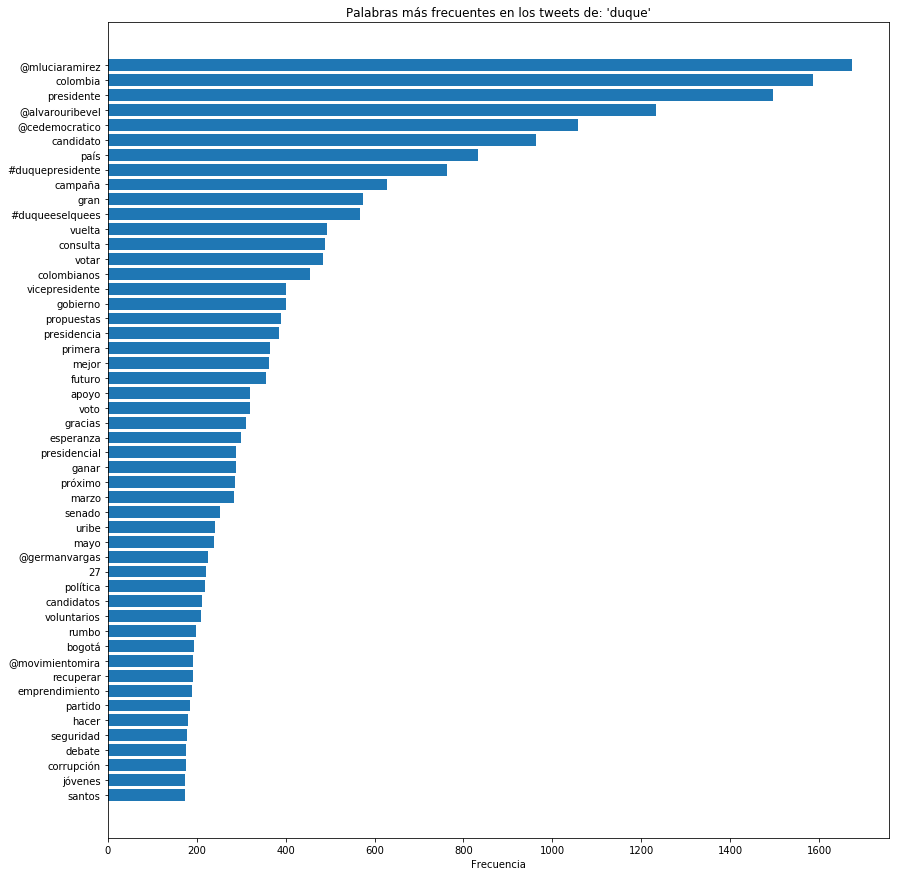

In [31]:
plot_data(most_frequent_no_stopwords, 'duque')

From this we can obtain some insights. Let's look at some of the words listed here:

* **`@mluciaramirez`** - This is the Twitter handle of the current vicepresident. So, it makes sense that it was the most common word on the tweets mentioning Duque.
* **`colombia`**, **`presidente`**, **`país`**, **`candidato`** - These explain themselves. We would have expected these to be among the most frequent words.
* **`@alvarouribevel`** - This is an interesting, yet obvious one. Álvaro Uribe is a former president who still has a lot of power over the country. He is the founder and leader of the Centro Democrático party. It makes sense that he is in the top 5 most common words, and it shows the power he still has.
* **`#duquepresidente`**, **`#duqueeselquees`** - These were hashtags used to promote Duque's candidacy.
* **`gran`** - This is another interesting one. Besides being a shortened adjective, it refers to the 'gran consulta por Colombia', and this can be confirmed by the fact that **`consulta`** appears only a couple of words below. The 'gran consulta por Colombia' referred to a vote, on which the people had to decide who they wanted to run for president. The Centro Democrático party encouraged people to vote for Duque for president and Marta Lucía Ramírez for vicepresident. This can be seen on this and the charts that will come next.
* **`vuelta`**, **`votar`**, **`voto`** - These all refer to voting. **`Vuelta`** refers to the stage of the elections. On the first stage, people could vote for candidates from the different parties. If one won by more than 50%, there's no second stage. If no one had more than 50%, the two candidates with the most votes moved on to the second stage. On these elections, these candidates were Iván Duque and Gustavo Petro.
* **`mejor`**, **`esperanza`**, **`recuperar`**, **`hacer`**, **`seguridad`**, **`corrupción`** - These are interesting because they somehow show what the people expected from the candidate. These words are talking about change. About **making** things **better**. About **hope**, **security**, and hopefully stopping **corruption**.
* **`santos`** - This is very revealing. Santos was the last president before Iván Duque. He signed the peace deal with Colombia's guerrilla FARC. He won a Nobel peace prize. And the Centro Democrático party hate him. He was elected as president because he was the minister of defense of Álvaro Uribe, and he was the candidate Álvaro Uribe promoted. Uribe basically got him elected, just as he got Iván Duque elected. And after being elected president, Juan Manuel Santos turned his back on Uribe, knowing all he had done. His name being among the most frequent words, reveals that people mentioning Ivan Duque on their tweets, use his name, most likely to talk bad about his ruling.

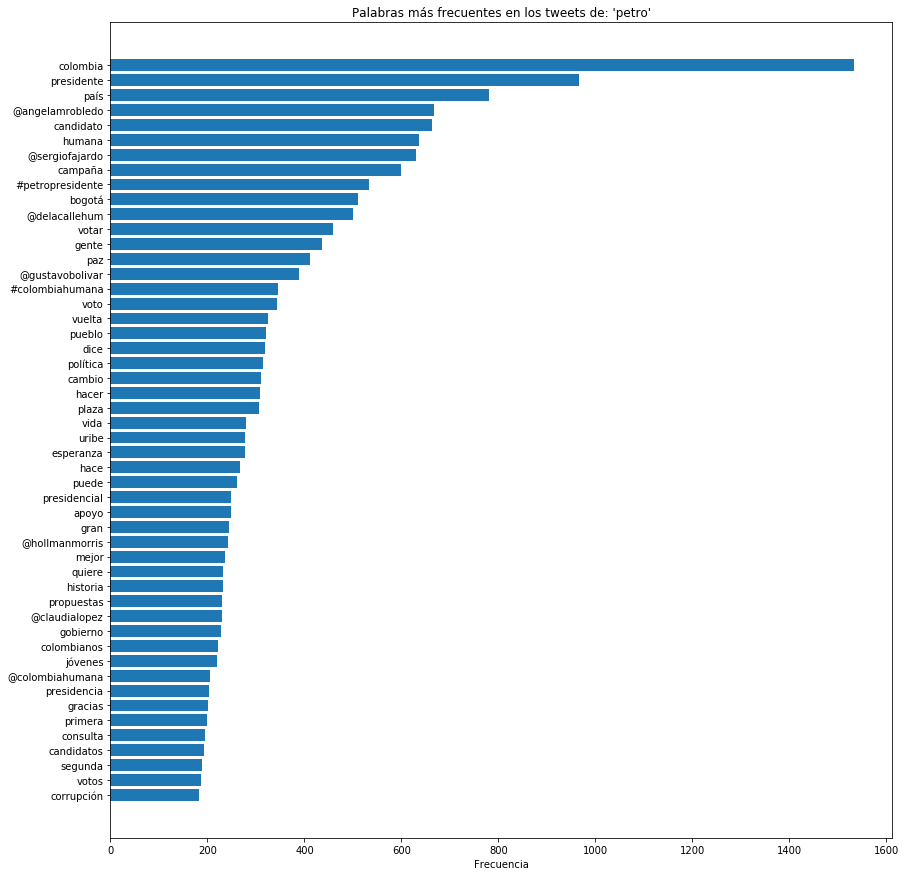

In [32]:
plot_data(most_frequent_no_stopwords, 'petro')

Now let's take a look at the most frequent words from the tweets mentioning Petro:

* **`Colombia`**, **`presidente`**, **`país`**, **`candidato`** - These also showed on Ivan Duque, but curiously enough, they had a higher position on the tweets mentioning Gustavo Petro than on those mentioning Ivan Duque.
* **`@angelamrobledo`** - As with Marta Lucía Ramírez, this is the Twitter handle for Petro's vicepresident, Ángela María Robledo. It makes sense that she is among the most frequent words.
* **`humana`** - This refers to Petro's party and proposal for Colombia. Colombia Humana is the name of his party, and he claimed he wanted to make Colombia more human.
* **`@sergiofajardo`** - This is an interesting one. Sergio Fajardo was another presidential candidate for these elections. It's not very clear why his name might have shown up here. It could be because of people asking for an alliance between him and Gustavo Petro.
* **`#petropresidente`**, **`#colombiahumana`** - These were hashtags used to promote his campaign.
* **`bogotá`** - Bogotá is the capital city of Colombia. Petro is a former mayor of Bogotá. This expleains its high frequency. This could be due to people mentioning his good or bad administration of the city to support or talk against his candidacy.
* **`@delacallehum`** - This is the Twitter handle for Humberto de la Calle. He played a key role on the peace negotiations with the FARC guerrilla under Santos' administration. He was also a presidential candidate for these elections. It's also possible that the people were asking for an alliance between him and Gustavo Petro.
* **`votar`**, **`voto`**, **`vuelta`** - These are the same as with Duque.
* **`@gustavobolivar`** - This is a really interesting one. Gustavo Bolívar is a senator, as well as a writer and journalist. He was the screenwriter for some of Colombia's most popular TV novels. He is part of the "Lista de los Decentes" party, a political coallition between various small parties, led by Gustavo Petro.
* **`paz`**, **`dice`**, **`cambio`**, **`hacer`**, **`vida`**, **`esperanza`**, **`hace`**, **`puede`**, **`mejor`**, **`corrupción`** - These are probably talking about what the people expected from Petro as well. Peace, first of all, as he promised to respect the peace deal (as opposed to Duque, who said he would tear it down). change, hope, life, better, all hopeful words. Can. Make. Does. And interestingly, says.
* **`historia`** - This is a big one. If Petro had been elected, it would have changed the history of the country. It would have broken with the usual schemes to keep power between the same parties always.
* **`jóvenes`** - Petro was probably most popular among the youth. This could be shown in this.
* **`gracias`** - Very self explanatory.

## Identifying most frequent bigrams and trigrams

Most frequent words might give us some insight. But, it might be even more useful to identify the most frequent bigrams and trigrams. These are, the most frequent combinations of two, and three words.

So, we'll first create a generic function to allow us to identify all of the n-grams of a tweet, and then we'll calculate the frequencies among all of the tweets.

In [33]:
def extract_ngrams(tweet, n):
    res = []
    as_list = [remove_special_characters(word) for word in tweet.split()]
    
    for i in range(0, len(as_list)):
        if i + (n - 1) < len(as_list): # We verify that an ngram can be made with what remains of the list
            ngram = " ".join(as_list[i:i + n]) # We create a string with the next n words
            res.append(ngram) # and we add it to the response without special chars
            
    return res

Now, we need to extract the ngrams from each of the tweet.

We don't extract the ngrams directly from the complete corpus because that would produce ngrams mixing tweets, because it would join the last word of the tweets with the first words of the next ones, thus producing ngrams that aren't really present.

In [34]:
# We add the bigrams to the df
df['bigrams'] = df['text'].apply(lambda x: extract_ngrams(x, 2))

# As well as the trigrams
df['trigrams'] = df['text'].apply(lambda x: extract_ngrams(x, 3))

# And I think it might be very interesting to add tetragrams and pentagrams as well
df['tetragrams'] = df['text'].apply(lambda x: extract_ngrams(x, 4))

df['pentagrams'] = df['text'].apply(lambda x: extract_ngrams(x, 5))

# And let's look at the resulting dataframe
df.head()

,text,favorited,retweeted,replies,user,lang,length,mentions_duque,mentions_petro,bigrams,trigrams,tetragrams,pentagrams
date,,,,,,,,,,,,,
2018-01-27 22:24:45,"Los ""pollos"" queremos un Presidente ""pollo"". U...",629,336,85,708108228568207360,es,197.0,True,False,"[los pollos, pollos queremos, queremos un, un ...","[los pollos queremos, pollos queremos un, quer...","[los pollos queremos un, pollos queremos un pr...","[los pollos queremos un presidente, pollos que..."
2018-01-27 21:51:25,Vota por @IvanDuque en la consulta @CeDemocrat...,793,535,136,149281495,es,121.0,True,False,"[vota por, por @ivanduque, @ivanduque en, en l...","[vota por @ivanduque, por @ivanduque en, @ivan...","[vota por @ivanduque en, por @ivanduque en la,...","[vota por @ivanduque en la, por @ivanduque en ..."
2018-01-27 21:46:13,.@FNAraujoR #4 Senado @IvanDuque #ElCandidato...,34,27,2,1069678676,es,300.0,True,False,"[@fnaraujor #4, #4 senado, senado @ivanduque, ...","[@fnaraujor #4 senado, #4 senado @ivanduque, s...","[@fnaraujor #4 senado @ivanduque, #4 senado @i...",[@fnaraujor #4 senado @ivanduque #elcandidatod...
2018-01-27 20:54:10,The girls flocking to see Mr. Duque. That's g...,1,0,0,876674787115925504,en,50.0,False,False,"[the girls, girls flocking, flocking to, to se...","[the girls flocking, girls flocking to, flocki...","[the girls flocking to, girls flocking to see,...","[the girls flocking to see, girls flocking to ..."
2018-01-27 19:11:12,"#FelizSábado, hoy durante reunión en Medellín ...",364,192,26,1115440213,es,197.0,True,False,"[#felizsábado hoy, hoy durante, durante reunió...","[#felizsábado hoy durante, hoy durante reunión...","[#felizsábado hoy durante reunión, hoy durante...","[#felizsábado hoy durante reunión en, hoy dura..."


Now let's put all of the candidates' ngrams together in their own lists

In [35]:
# We create arrays to store our data

duque_bigrams, petro_bigrams, whole_bigrams = [], [], []
duque_trigrams, petro_trigrams, whole_trigrams = [], [], []
duque_tetragrams, petro_tetragrams, whole_tetragrams = [], [], []
duque_pentagrams, petro_pentagrams, whole_pentagrams = [], [], []

# And we iterate over the dataframe, adding to the different arrays accordingly
for (_, x) in df.iterrows():
    if x['mentions_duque'] and not x['mentions_petro']:
        duque_bigrams += x['bigrams']
        duque_trigrams += x['trigrams']
        duque_tetragrams += x['tetragrams']
        duque_pentagrams += x['pentagrams']
    elif x['mentions_petro'] and not x['mentions_duque']:
        petro_bigrams += x['bigrams']
        petro_trigrams += x['trigrams']
        petro_tetragrams += x['tetragrams']
        petro_pentagrams += x['pentagrams']
    else:
        whole_bigrams += x['bigrams']
        whole_trigrams += x['trigrams']
        whole_tetragrams += x['tetragrams']
        whole_pentagrams += x['pentagrams']

And finally, let's calculate the frequencies

In [36]:
# We create dicts to store the different frequency objects.
duque_bigrams_freq, petro_bigrams_freq, whole_bigrams_freq = {}, {}, {}
duque_trigrams_freq, petro_trigrams_freq, whole_trigrams_freq = {}, {}, {}

# These are some common bigrams that don't really add to the analysis. We'll be removing these.
stop_bigrams = ["de la", "de @ivanduque", "a la", "en la", "en el", "con el", 
           "@ivanduque y", "de los", "@ivanduque en", "a los", "por el",
           "con la", "con los", "a las", "para que", "y la", "y el", "es el",
           "por la", "de las", "que @ivanduque", "@ivanduque es", "lo que",
           "@petrogustavo y", "en los", "@petrogustavo en", "que @petrogustavo",
           "de las", "que no", "no se", "que se", "no se", "es la", "que el",
           "para que", "es un", "y no", "todos los", "que le", "en las", "por eso",
            "no es", "y a", "presidente y", "en las", "a @ivanduque", "y @mluciaramirez",
            "presidente de", "de nuestro", "gobierno de", "@ivanduque el", "para la",
            "de @petrogustavo", "a @petrogustavo", "@petrogustavo es", "y @angelamrobledo",
            "y @petrogustavo", "que la", "en su", "es que", "y de", "los que", "que los",
            "de un", "de su", "@petrogustavo por", "@ivanduque ", "@petrogustavo ",
            "@ivanduque a", "por qué", "@petrogustavo a", "es una", "de que", "y los", "el que",
            "@sergiofajardo y", "@petrogustavo que", "para el", "por una", "y que", "que es",
            "@petrogustavo se", "@petrogustavo el", "que en", "de una", "no le", " @petrogustavo",
            "no le", "hay que", "que lo", "en este", "que nos", "y su", "en una", "y en", "hoy en",
            "con las", "@petrogustavo con", "@petrogustavo para", "en un", "no hay"]

# And we populate the bigram dicts, ignoring the "stop bigrams"
for bigram in duque_bigrams:
    if bigram not in stop_bigrams:
        duque_bigrams_freq[bigram] = duque_bigrams_freq.get(bigram, 0) + 1

for bigram in petro_bigrams:
    if bigram not in stop_bigrams:
        petro_bigrams_freq[bigram] = petro_bigrams_freq.get(bigram, 0) + 1
    
for bigram in whole_bigrams:
    if bigram not in stop_bigrams:
        whole_bigrams_freq[bigram] = whole_bigrams_freq.get(bigram, 0) + 1

# These are some common trigrams that don't really add to the analysis. We'll be removing these.
stop_trigrams = ["de @ivanduque y", "con @ivanduque y", "a @ivanduque y", "@ivanduque en la",
                 "a todos los", "por @ivanduque y", "de @ivanduque en", "de @petrogustavo en",
                 "de @petrogustavo y", "a @petrogustavo en", "a @petrogustavo y", "@petrogustavo en la",
                 "con @petrogustavo y", "por @petrogustavo y", "de @petrogustavo es", "de @petrogustavo ",
                 "@petrogustavo es el", "a @petrogustavo ", "uno de los", "@petrogustavo en el",
                 "@petrogustavo es un", "de @petrogustavo a", "que @petrogustavo es", "de campaña de",
                 "@ivanduque presidente y", "@petrogustavo presidente y", "@petrogustavo a la",
                 "@petrogustavo y la"]

# And we populate the trigram dicts, ignoring the "stop trigrams"
for trigram in duque_trigrams:
    if trigram not in stop_trigrams:
        duque_trigrams_freq[trigram] = duque_trigrams_freq.get(trigram, 0) + 1

for trigram in petro_trigrams:
    if trigram not in stop_trigrams:
        petro_trigrams_freq[trigram] = petro_trigrams_freq.get(trigram, 0) + 1
    
for trigram in whole_trigrams:
    if trigram not in stop_trigrams:
        whole_trigrams_freq[trigram] = whole_trigrams_freq.get(trigram, 0) + 1

Great! Now we can sort these and get some insights.

In [37]:
most_frequent_bigrams = {
    'duque': sorted(duque_bigrams_freq.items(), key=lambda kv: kv[1], reverse=True),
    'petro': sorted(petro_bigrams_freq.items(), key=lambda kv: kv[1], reverse=True),
    'whole': sorted(whole_bigrams_freq.items(), key=lambda kv: kv[1], reverse=True)
}

most_frequent_trigrams = {
    'duque': sorted(duque_trigrams_freq.items(), key=lambda kv: kv[1], reverse=True),
    'petro': sorted(petro_trigrams_freq.items(), key=lambda kv: kv[1], reverse=True),
    'whole': sorted(whole_trigrams_freq.items(), key=lambda kv: kv[1], reverse=True)
}

## Visualizing most frequent bigrams and trigrams

Now that we've identified the most frequent bigrams and trigrams, we can visualize them, to get some insights.

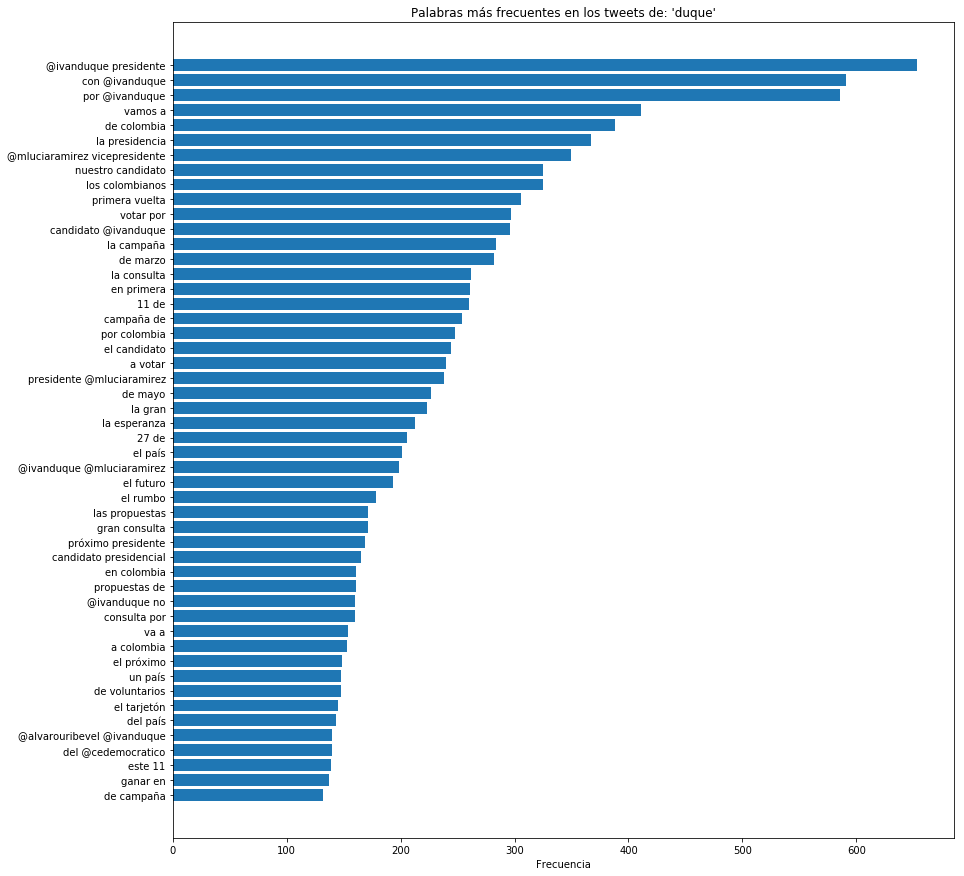

In [93]:
plot_data(most_frequent_bigrams, 'duque')

Now, let's analyze these a little:

* **`@ivanduque presidente`**, **`con @ivanduque`**, **`por @ivanduque`** - These all show support for the candidate. They are the most common.
* **`vamos a`** - This might seem like a stopword. However, it was deliberately kept, because it talks about the feeling held by the people. Of being sort of a team with the candidate. And believing that they, included were going to do something.
* **`@mluciaramirez vicepresidente`** - As was mentioned on the unigrams analysis, the campaign initially made a lot of emphasis on choosing Ivan Duque for president and Marta Lucía Ramírez for vicepresident. It's very interesting, really. And it could be that they assumed that it would be easier to make Ivan Duque win, for he was an absolute nobody.
* **`la consulta`** - This, again, refers to the 'Gran consulta por Colombia', on which they were to set the roles for Ivan Duque and Marta Lucía Ramírez.
* **`va a`** - Again as with 'vamos a', it talks about what the candidate will do.
* **`@ivanduque no`** - This one is quite interesting. It could be people defending him from other people, or people saying that he doesn't have what it takes to be president, or that he doesn't have any political experience, or that he's just not a good candidate. This is just speculation, but it's still interesting.
* **`@alvarouibevel @ivanduque`** - This is interesting as well. It puts Duque next to Uribe, even mentioning Uribe first. I think this just shows Uribe's power once more.
* The rest of the bigrams aren't really too interesting or too relevant. They show support and talk about expectations of what Duque will do.

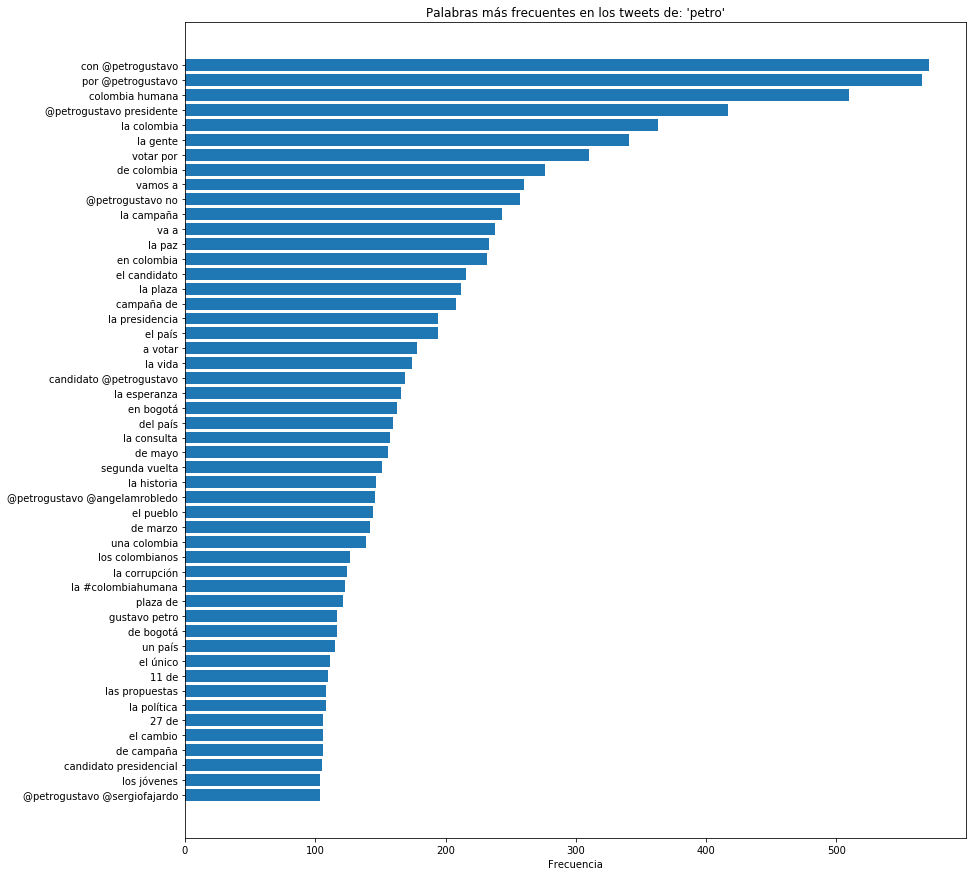

In [115]:
plot_data(most_frequent_bigrams, 'petro')

Let's analyze these ones:

* **`con @petrogustavo`**, **`por @petrogustavo`**, **`@petrogustavo presidente`** **`colombia humana`**- These all show support for the candidate.
* **`@petrogustavo no`** - This, as with Duque, most likely expresses something negative. However, on the tweets mentioning Gustavo Petro, this has a much higher frequency.
* **`va a`**, **`vamos a`** - These, again, shows that the people are talking about what the candidate will do, and that they feel identified with him.
* **`la vida`**, **`la esperanza`**, **`la historia`** - These are hopeful words supporting the candidate.
* **`el pueblo`** - This is kind of interesting. For it shows that in fact the people are more identified with Gustavo Petro.

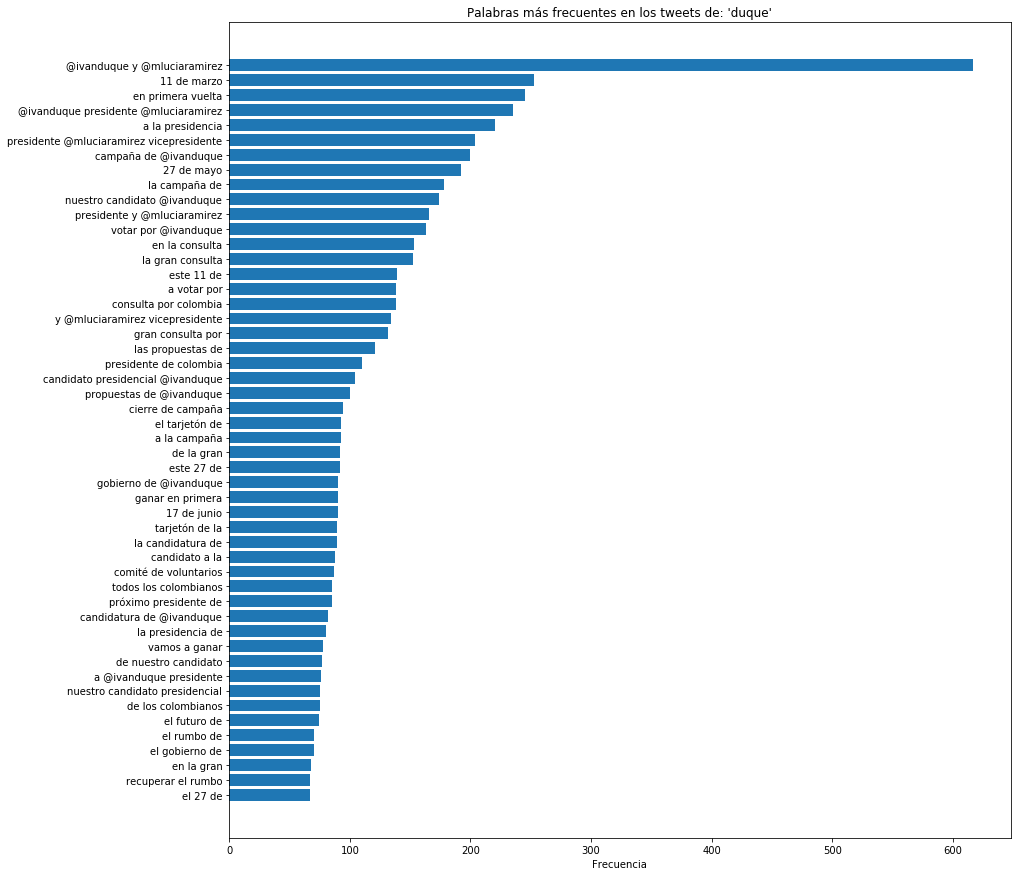

In [126]:
plot_data(most_frequent_trigrams, 'duque')

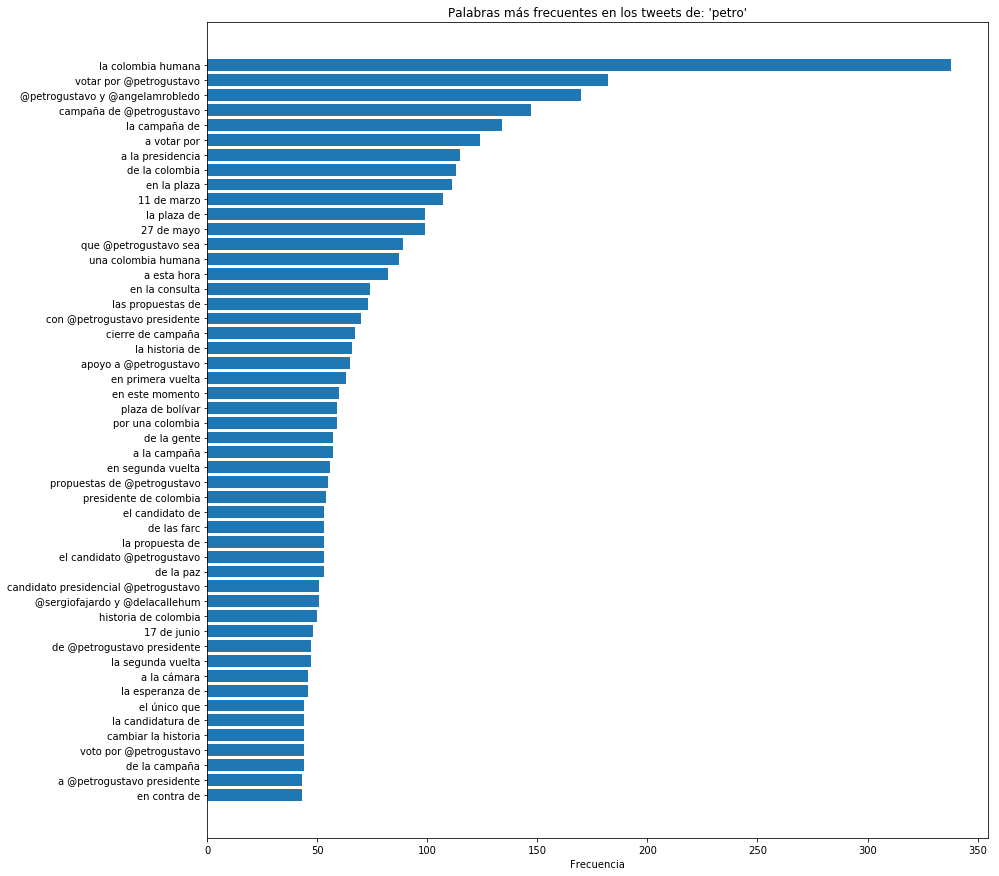

In [130]:
plot_data(most_frequent_trigrams, 'petro')

In [108]:
duque_tetragrams_freq, petro_tetragrams_freq, whole_tetragrams_freq = {}, {}, {}
duque_pentagrams_freq, petro_pentagrams_freq, whole_pentagrams_freq = {}, {}, {}

for tetragram in duque_tetragrams:
    duque_tetragrams_freq[tetragram] = duque_tetragrams_freq.get(tetragram, 0) + 1

for tetragram in petro_tetragrams:
    petro_tetragrams_freq[tetragram] = petro_tetragrams_freq.get(tetragram, 0) + 1
    
for tetragram in whole_tetragrams:
    whole_tetragrams_freq[tetragram] = whole_tetragrams_freq.get(tetragram, 0) + 1
    
for pentagram in duque_pentagrams:
    duque_pentagrams_freq[pentagram] = duque_pentagrams_freq.get(pentagram, 0) + 1

for pentagram in petro_pentagrams:
    petro_pentagrams_freq[pentagram] = petro_pentagrams_freq.get(pentagram, 0) + 1
    
for pentagram in whole_pentagrams:
    whole_pentagrams_freq[pentagram] = whole_pentagrams_freq.get(pentagram, 0) + 1

In [109]:
most_frequent_tetragrams = {
    'duque': sorted(duque_tetragrams_freq.items(), key=lambda kv: kv[1], reverse=True),
    'petro': sorted(petro_tetragrams_freq.items(), key=lambda kv: kv[1], reverse=True),
    'whole': sorted(whole_tetragrams_freq.items(), key=lambda kv: kv[1], reverse=True)
}

most_frequent_pentagrams = {
    'duque': sorted(duque_pentagrams_freq.items(), key=lambda kv: kv[1], reverse=True),
    'petro': sorted(petro_pentagrams_freq.items(), key=lambda kv: kv[1], reverse=True),
    'whole': sorted(whole_pentagrams_freq.items(), key=lambda kv: kv[1], reverse=True)
}

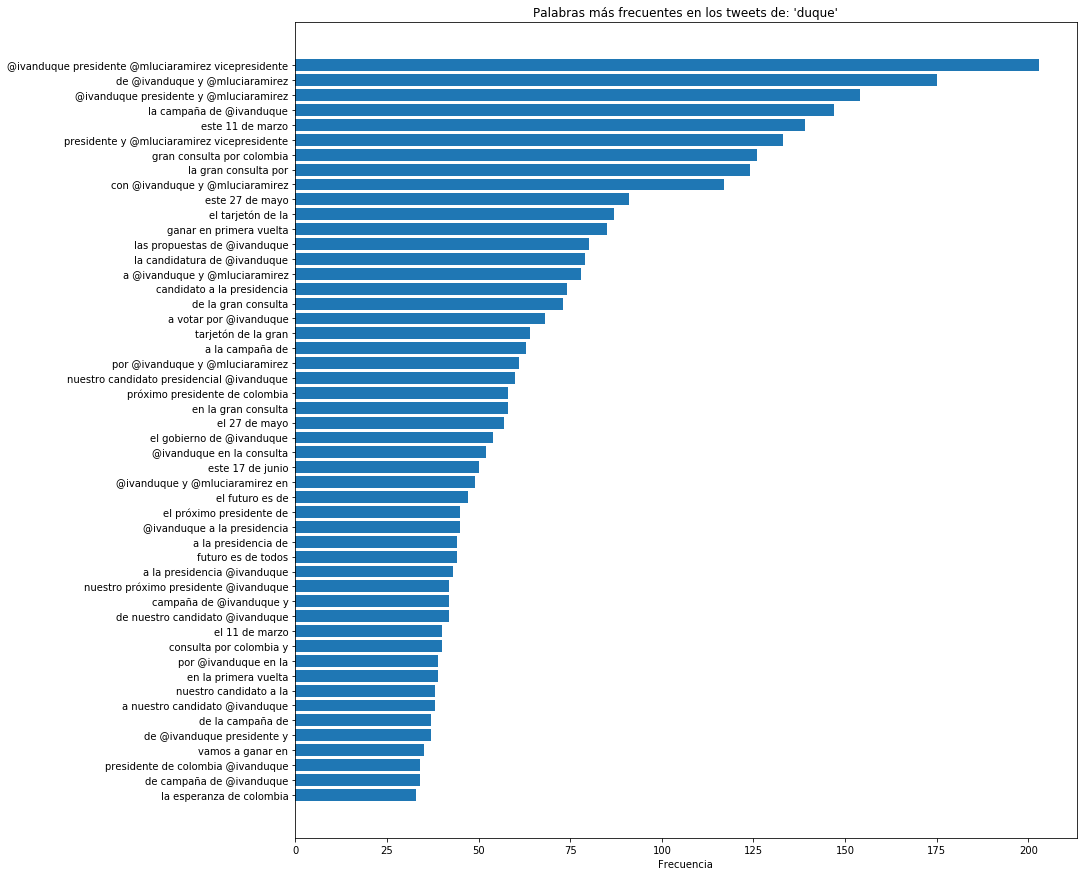

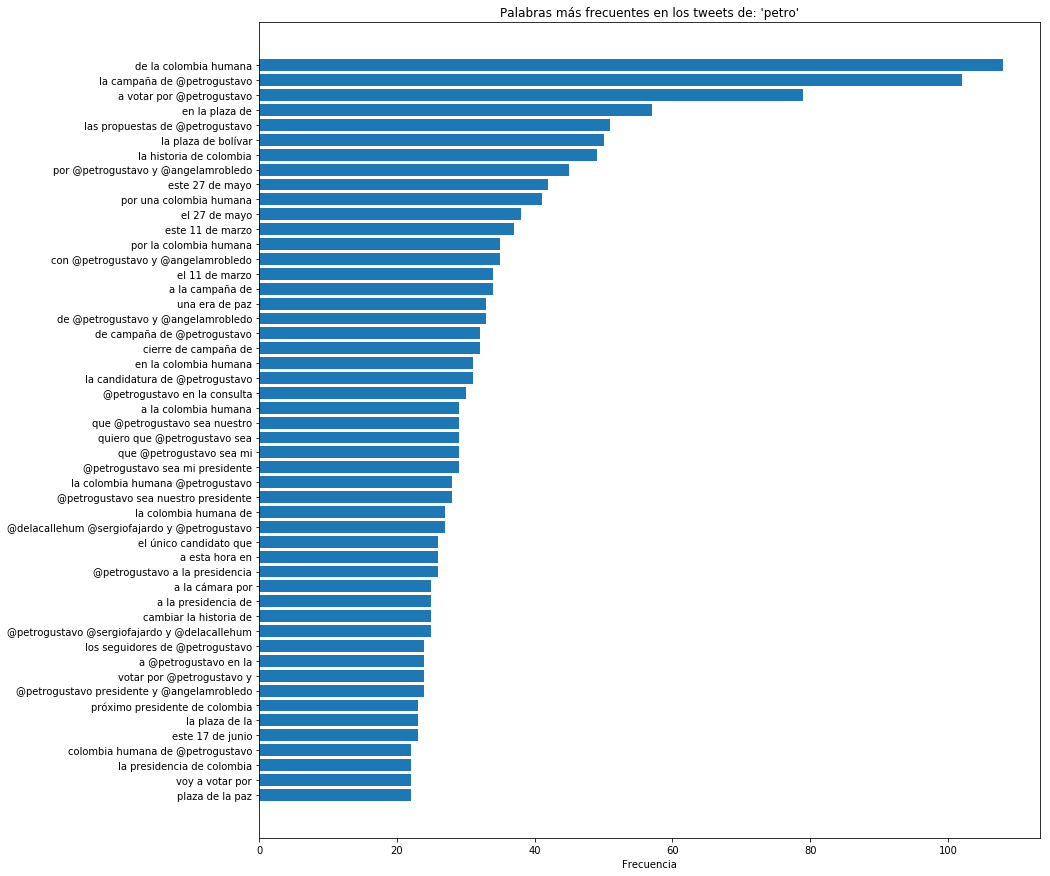

In [110]:
plot_data(most_frequent_tetragrams, 'duque')

plot_data(most_frequent_tetragrams, 'petro')

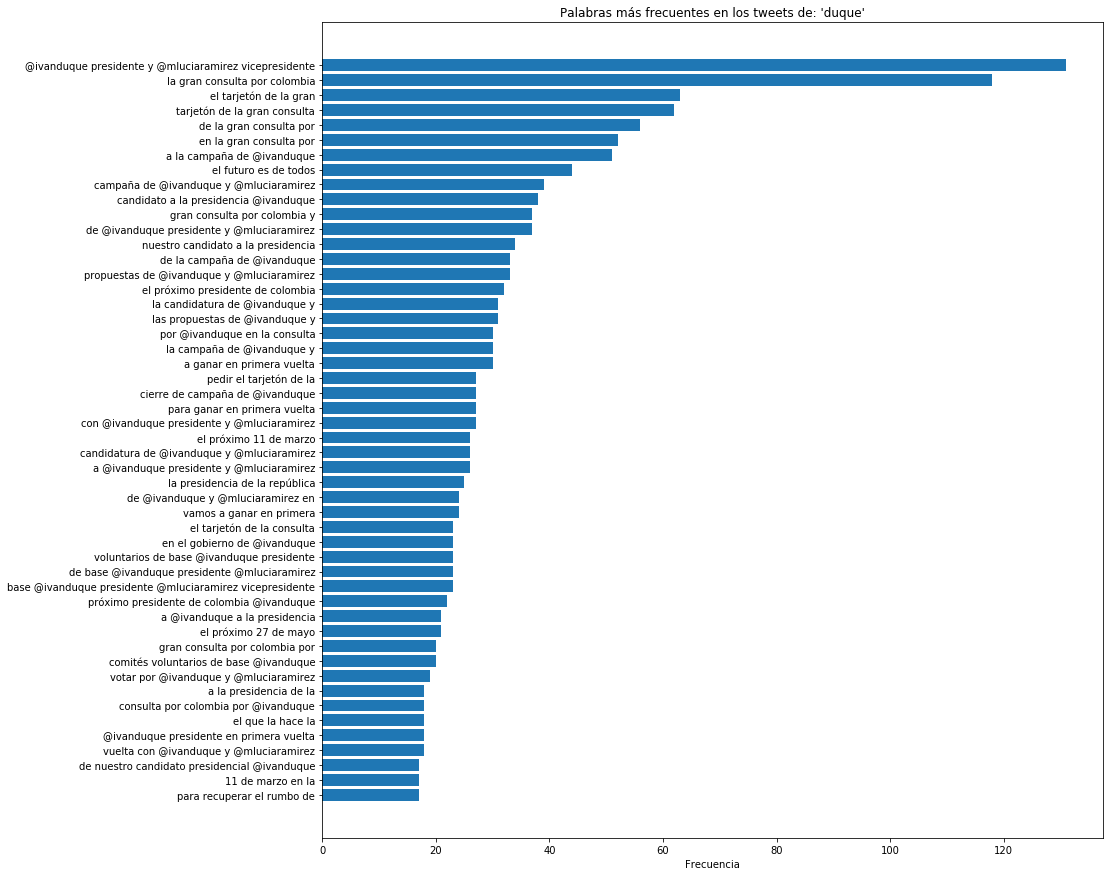

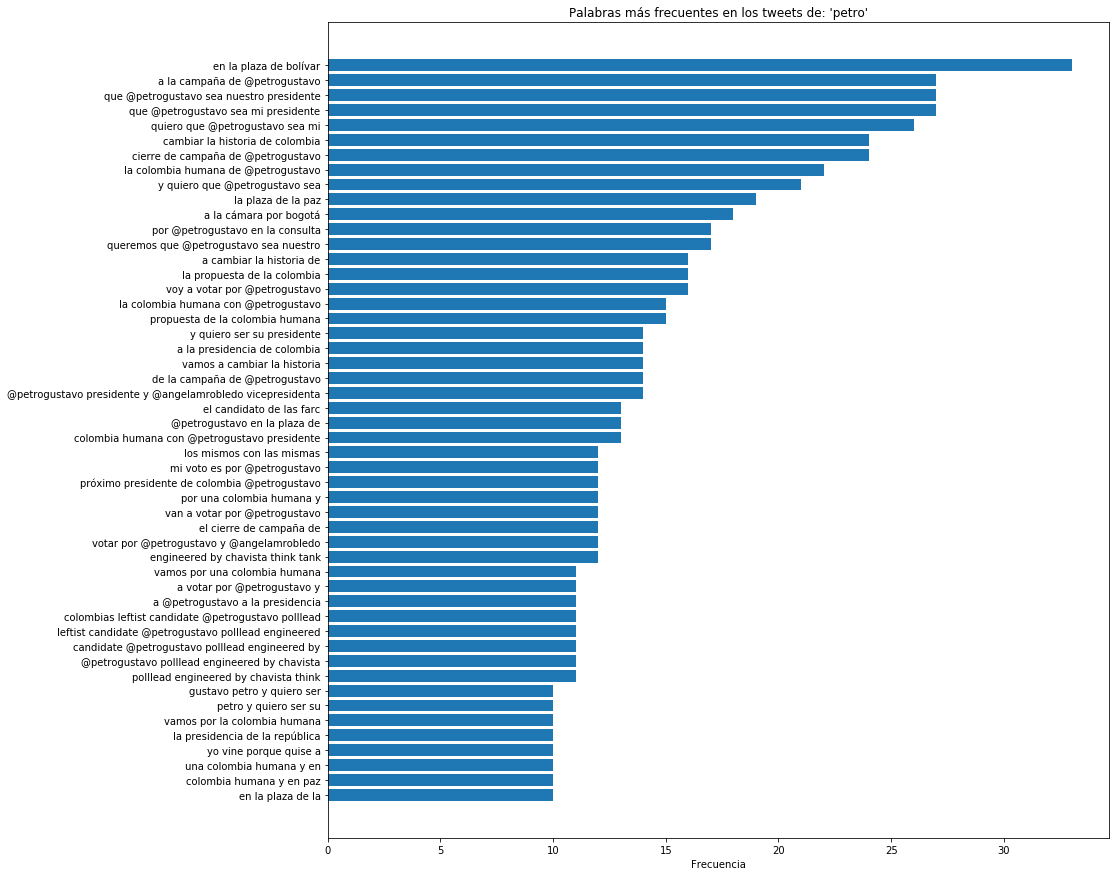

In [112]:
plot_data(most_frequent_pentagrams, 'duque')

plot_data(most_frequent_pentagrams, 'petro')